In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from statsmodels.tsa.arima.model import ARIMA
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from statsmodels.tsa.ar_model import AutoReg
from statsmodels.tsa.arima.model import ARIMA
from sklearn.metrics import mean_squared_error
from statsmodels.tsa.stattools import adfuller



In [2]:
data = pd.read_excel('/Users/alejandroporras/Desktop/data.xlsx')

In [3]:
diferencia = data.iloc[4:-12]

In [4]:
# Drop specific columns from the data DataFrame
columns_to_drop = ['Change', 'Growth'] 
data.drop(columns=columns_to_drop, inplace=True)

In [5]:
# Assuming 'Date' column is in datetime format
data['Date'] = pd.to_datetime(data['Date'])

In [6]:
# Set 'Date' as the index
data.set_index('Date', inplace=True)

# Sort the data by date
data.sort_index(inplace=True)

In [7]:
# Remove 'B' from revenue and convert to numeric
data['Revenue'] = data['Revenue'].str.replace('B', '').astype(float) * 1e9

# Convert 'Revenue' column to numeric (in case it's not already)
data['Revenue'] = pd.to_numeric(data['Revenue'])


In [8]:
# Assuming 'diferencia' is your DataFrame
# Replace 'M' and 'B' with scaling factors and convert to float
diferencia["Change"] = (
    diferencia['Change']
    .replace(r'([0-9.]+)M', r'\1e6', regex=True)  # Replace 'M' with * 1e6
    .replace(r'([0-9.]+)B', r'\1e9', regex=True)  # Replace 'B' with * 1e9
    .astype(float)  # Convert to float
)



/var/folders/38/s_4w5wrd7h7bj29_g6nnxv2h0000gn/T/ipykernel_22340/2818472690.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  diferencia["Change"] = (


In [9]:
df_new = data[:-12]

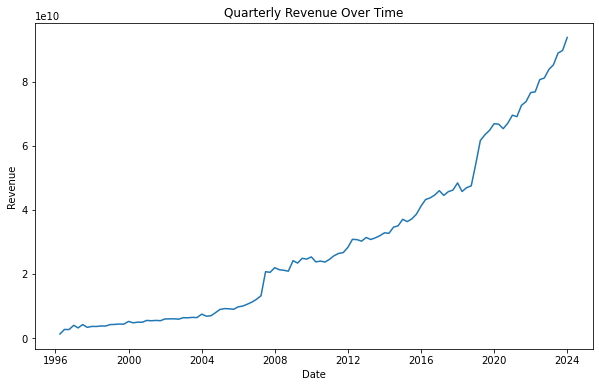

In [10]:
# plot the data to visualize it
plt.figure(figsize=(10, 6))
plt.plot(data['Revenue'])
plt.title('Quarterly Revenue Over Time')
plt.xlabel('Date')
plt.ylabel('Revenue')
plt.show()

In [11]:
import numpy as np
from sklearn.metrics import mean_squared_error

window_size = 4  # Choose the size of the moving average window (4 quarters for quarterly data)
moving_avg = df_new['Revenue'].rolling(window=window_size).mean()

# Drop NaN values from the moving average
moving_avg = moving_avg.dropna()

# Assuming you have actual values (true values) for comparison
actual_values = df_new["Revenue"]  # Replace 'Actual_Revenue' with your actual revenue column name

# Calculate Mean Squared Error (MSE)
mse = mean_squared_error(actual_values[window_size - 1:], moving_avg)
print("Mean Squared Error (MSE):", mse)


Mean Squared Error (MSE): 4.163631708715596e+18


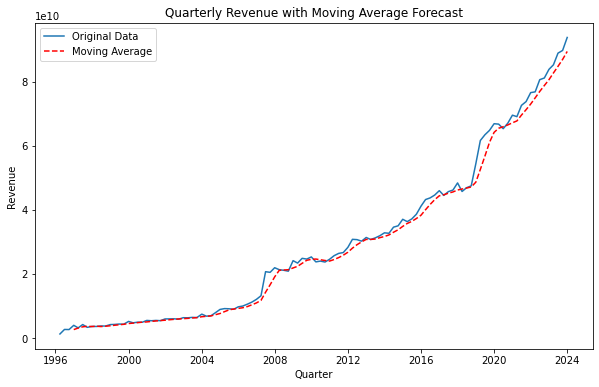

In [12]:
# Plot the original data and moving average
plt.figure(figsize=(10, 6))
plt.plot(df_new['Revenue'], label='Original Data')
plt.plot(moving_avg, label='Moving Average', linestyle='--', color='red')


plt.title('Quarterly Revenue with Moving Average Forecast')
plt.xlabel('Quarter')
plt.ylabel('Revenue')
plt.legend()
plt.show()

In [13]:
# Check for very large values
if data['Revenue'].max() > 1e10:
    print("Warning: Very large values found in the data. Scaling down for better model performance.")
    data['Revenue'] = data['Revenue'] / 1e9  # Scale down by dividing by 1 billion

In [14]:
# Check for missing values
missing_values = data.isnull().sum()
if missing_values.any():
    print("Warning: Missing values found in the data. Interpolating to fill the gaps.")
    data = data.interpolate(method='linear')


CAMBIAR A DF_NEW PARA 2024-2026

In [15]:
df_new = df_new[:-4]

In [16]:
df_new

,Revenue,Period,Quarter
Date,,,
1996-03-30,1.26,1,1
1996-06-29,2.67,2,2
1996-09-28,2.64,3,3
1996-12-31,3.96,4,4
1997-03-29,3.16,5,1
...,...,...,...
2021-12-31,76.60,104,4
2022-03-31,76.83,105,1
2022-06-30,80.64,106,2


We check for stationarity in the model to be sure that an ARIMA model is appropiate to use

ADF Statistic: 3.52508601600038
p-value: 1.0
Critical Values:
	1%: -3.4961490537199116
	5%: -2.8903209639580556
	10%: -2.5821223452518263
Fail to reject the null hypothesis - Data is non-stationary


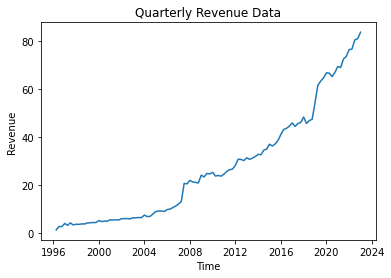

In [17]:

revenue_series = df_new['Revenue']

# Define a function to perform the ADF test
def adf_test(timeseries):
    # Perform Dickey-Fuller test
    result = adfuller(timeseries)
    print('ADF Statistic:', result[0])
    print('p-value:', result[1])
    print('Critical Values:')
    for key, value in result[4].items():
        print('\t{}: {}'.format(key, value))
    if result[1] <= 0.05:
        print("Reject the null hypothesis - Data is stationary")
    else:
        print("Fail to reject the null hypothesis - Data is non-stationary")

# Perform ADF test on the revenue data
adf_test(revenue_series)

# Plot the revenue data
plt.plot(revenue_series)
plt.title('Quarterly Revenue Data')
plt.xlabel('Time')
plt.ylabel('Revenue')
plt.show()

As the model is non-stationary, we check if the log revenue its stattionary

ADF Statistic: -1.1068161023034242
p-value: 0.7123460818061171
Critical Values:
	1%: -3.497501033
	5%: -2.89090644
	10%: -2.5824349
Fail to reject the null hypothesis - Data is non-stationary


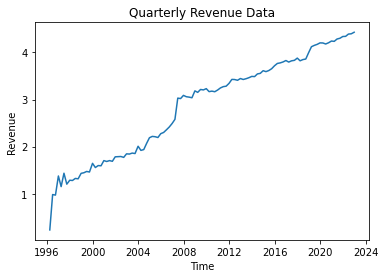

In [18]:
df_new['Log_Revenue'] = np.log(df_new['Revenue'])
result = adfuller(df_new['Log_Revenue'].dropna())

#Comparing with the change from one quarter to the same quarter last year
revenue_series3 = df_new['Log_Revenue']

# Define a function to perform the ADF test
def adf_test(timeseries):
    # Perform Dickey-Fuller test
    result = adfuller(timeseries)
    print('ADF Statistic:', result[0])
    print('p-value:', result[1])
    print('Critical Values:')
    for key, value in result[4].items():
        print('\t{}: {}'.format(key, value))
    if result[1] <= 0.05:
        print("Reject the null hypothesis - Data is stationary")
    else:
        print("Fail to reject the null hypothesis - Data is non-stationary")

# Perform ADF test on the revenue data
adf_test(revenue_series3)

# Plot the revenue data
plt.plot(revenue_series3)
plt.title('Quarterly Revenue Data')
plt.xlabel('Time')
plt.ylabel('Revenue')
plt.show()

As the model is still not stationary, we differenciate it with the same quarter last year

ADF Statistic: -0.5504789311440483
p-value: 0.8817838322851727
Critical Values:
	1%: -3.5011373281819504
	5%: -2.8924800524857854
	10%: -2.5832749307479226
Fail to reject the null hypothesis - Data is non-stationary


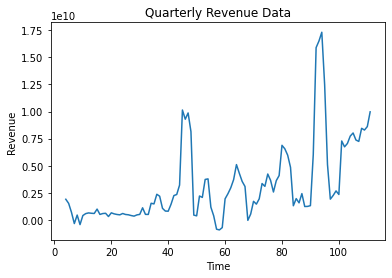

In [19]:
#Comparing with the change from one quarter to the same quarter last year
revenue_series2 = diferencia['Change']

# Define a function to perform the ADF test
def adf_test(timeseries):
    # Perform Dickey-Fuller test
    result = adfuller(timeseries)
    print('ADF Statistic:', result[0])
    print('p-value:', result[1])
    print('Critical Values:')
    for key, value in result[4].items():
        print('\t{}: {}'.format(key, value))
    if result[1] <= 0.05:
        print("Reject the null hypothesis - Data is stationary")
    else:
        print("Fail to reject the null hypothesis - Data is non-stationary")

# Perform ADF test on the revenue data
adf_test(revenue_series2)

# Plot the revenue data
plt.plot(revenue_series2)
plt.title('Quarterly Revenue Data')
plt.xlabel('Time')
plt.ylabel('Revenue')
plt.show()

Still not stationary, so we differenciate it with the last quarter (t-1).

ADF Statistic: -3.334554712444991
p-value: 0.013402786193903084
Critical Values:
	1%: -3.4968181663902103
	5%: -2.8906107514600103
	10%: -2.5822770483285953
Reject the null hypothesis - Data is stationary


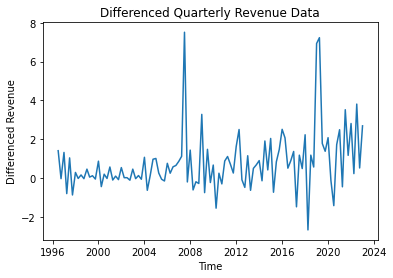

In [20]:
# Take first differences of the revenue data
revenue_diff = revenue_series.diff().dropna()

# Perform ADF test on the differenced data
adf_test(revenue_diff)

# Plot the differenced revenue data
plt.plot(revenue_diff)
plt.title('Differenced Quarterly Revenue Data')
plt.xlabel('Time')
plt.ylabel('Differenced Revenue')
plt.show()


Now that the data is stationary, we look the order of the ARIMA (p,d,q), with a autocorrelation function

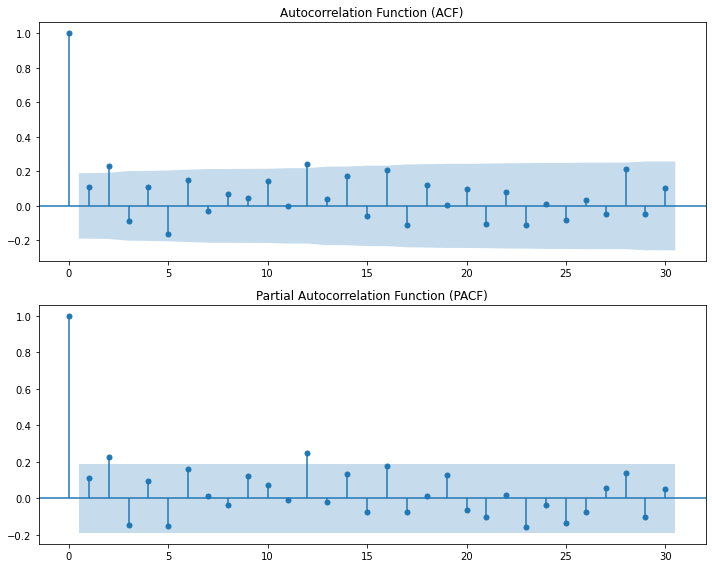

In [21]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

# Plot ACF and PACF
fig, axes = plt.subplots(2, 1, figsize=(10, 8))

# ACF plot
plot_acf(revenue_diff, lags=30, ax=axes[0])
axes[0].set_title('Autocorrelation Function (ACF)')

# PACF plot
plot_pacf(revenue_diff, lags=30, ax=axes[1])
axes[1].set_title('Partial Autocorrelation Function (PACF)')

plt.tight_layout()
plt.show()

After looking at the autocorrelation function we can see that the data is affected by the second last observation. 
Then P=2 D=0 as the model is already differenciate it and Q=0 given that doesnt affect the model

In [22]:
from statsmodels.tsa.arima.model import ARIMA

# Fit ARIMA model 
model = ARIMA(revenue_diff, order=(2, 0, 1), trend="c")
arima_result = model.fit()

# Print model summary
print(arima_result.summary())


/Users/alejandroporras/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:581: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  warnings.warn('A date index has been provided, but it has no'
/Users/alejandroporras/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:581: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  warnings.warn('A date index has been provided, but it has no'
/Users/alejandroporras/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:581: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  warnings.warn('A date index has been provided, but it has no'


                               SARIMAX Results                                
Dep. Variable:                Revenue   No. Observations:                  107
Model:                 ARIMA(2, 0, 1)   Log Likelihood                -188.226
Date:                Sun, 25 Feb 2024   AIC                            386.453
Time:                        22:54:05   BIC                            399.817
Sample:                             0   HQIC                           391.870
                                - 107                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.7720      0.255      3.032      0.002       0.273       1.271
ar.L1         -0.7415      0.081     -9.198      0.000      -0.900      -0.584
ar.L2          0.2583      0.078      3.295      0.0

Now, we test the model.

In [23]:
# Forecast using the ARIMA model
forecast_steps = len(revenue_diff)  # Forecast for the same length as the original data
forecast = arima_result.predict(start=1, end=forecast_steps)  # Start at 1 due to differencing

# Calculate Mean Squared Error (MSE)
mse = mean_squared_error(revenue_diff, forecast)
print("Mean Squared Error (MSE):", mse)

Mean Squared Error (MSE): 1.9924428523050068


/Users/alejandroporras/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:376: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  warnings.warn('No supported index is available.'


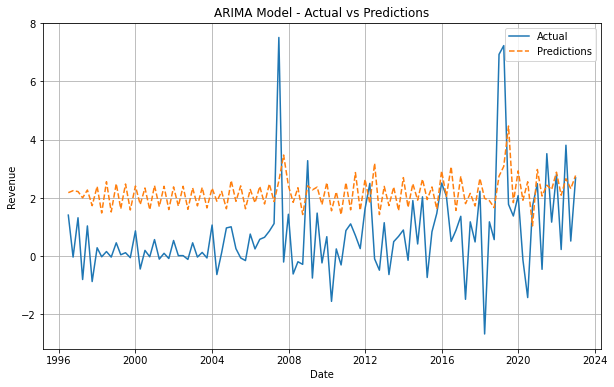

In [24]:
import pandas as pd
import matplotlib.pyplot as plt
from statsmodels.tsa.arima.model import ARIMA

# Assuming you have the arima_result object and the original revenue_diff data

# Generate predictions
predictions = arima_result.predict(typ='levels')
# Add the first element of the original series to undo differencing
predictions = pd.Series(predictions, index=revenue_diff.index)
predictions = predictions.add(revenue_diff.iloc[0])

# Plotting
plt.figure(figsize=(10, 6))
plt.plot(revenue_diff, label='Actual')
plt.plot(predictions, label='Predictions', linestyle='--')
plt.title('ARIMA Model - Actual vs Predictions')
plt.xlabel('Date')
plt.ylabel('Revenue')
plt.legend()
plt.grid(True)
plt.show()


After checking that the model is accuarte, we forecast the difference of the next 12 periods; 3 years

In [25]:
revenue_diff_df = pd.DataFrame(revenue_diff)
print(revenue_diff_df)

            Revenue
Date               
1996-06-29     1.41
1996-09-28    -0.03
1996-12-31     1.32
1997-03-29    -0.80
1997-06-28     1.04
...             ...
2021-12-31     2.81
2022-03-31     0.23
2022-06-30     3.81
2022-09-30     0.52
2022-12-31     2.69

[107 rows x 1 columns]


In [26]:
# Forecast the next 12 periods
forecast_steps = 16
forecast = arima_result.forecast(steps=forecast_steps)

/Users/alejandroporras/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:376: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  warnings.warn('No supported index is available.'


In [27]:
forecast

107    0.598971
108    1.395646
109    0.264826
110    1.309129
111    0.242681
112    1.303205
113    0.241355
114    1.302659
115    0.241417
116    1.302471
117    0.241572
118    1.302308
119    0.241733
120    1.302146
121    0.241895
122    1.301985
Name: predicted_mean, dtype: float64

In [28]:
import pandas as pd

# Sample data for predicted growth
predicted_growth = pd.DataFrame({
    'predicted_mean': [0.598971, 1.395646, 0.264826, 1.309129, 0.242681, 1.303205,
                       0.241355, 1.302659, 0.241417, 1.302471, 0.241572, 1.302308,
                       0.241733, 1.302146, 0.241895, 1.301985]
})

# Get the last value of df_new
last_value = df_new.iloc[-1]['Revenue']

# Iterate through predicted_growth and add to df_new
for index, row in predicted_growth.iterrows():
    last_value += row['predicted_mean']
    df_new = df_new.append({'Revenue': last_value}, ignore_index=True)

print(df_new)


       Revenue  Period  Quarter  Log_Revenue
0     1.260000     1.0      1.0     0.231112
1     2.670000     2.0      2.0     0.982078
2     2.640000     3.0      3.0     0.970779
3     3.960000     4.0      4.0     1.376244
4     3.160000     5.0      1.0     1.150572
..         ...     ...      ...          ...
119  93.596240     NaN      NaN          NaN
120  93.837973     NaN      NaN          NaN
121  95.140119     NaN      NaN          NaN
122  95.382014     NaN      NaN          NaN
123  96.683999     NaN      NaN          NaN

[124 rows x 4 columns]


In [29]:
QPredictions=df_new[-16:]
columns_to_drop = ['Period', 'Quarter'] 
QPredictions.drop(columns=columns_to_drop, inplace=True)

/Users/alejandroporras/opt/anaconda3/lib/python3.9/site-packages/pandas/core/frame.py:4906: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return super().drop(


In [30]:
QPredictions

,Revenue,Log_Revenue
108,84.448971,NaN
109,85.844617,NaN
110,86.109443,NaN
111,87.418572,NaN
112,87.661253,NaN
113,88.964458,NaN
114,89.205813,NaN
115,90.508472,NaN
116,90.749889,NaN
117,92.052360,NaN


In [31]:
# Create a list of grouped values
Revenue = [
    QPredictions.iloc[:4].sum()['Revenue'],
    QPredictions.iloc[4:8].sum()['Revenue'],
    QPredictions.iloc[8:12].sum()['Revenue'],
    QPredictions.iloc[12:].sum()['Revenue']
]

# Create a new DataFrame with grouped values
Predictions = pd.DataFrame({
    'Year': [2023, 2024, 2025,2026],
    'Revenue': Revenue
    
})

print(Predictions)



   Year     Revenue
0  2023  343.821603
1  2024  356.339996
2  2025  368.692421
3  2026  381.044105
